In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import act_max_util as amu

from autoencoder import Autoencoder
from solver import *

%load_ext autoreload
%autoreload 2

### Load data

In [3]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

### Activation Maximization

In [4]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

### Load Model

In [5]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32]

In [6]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

### RFA For Every Model For Different Models

In [102]:
# For all different models
sae_rf_matrices = []
dae_rf_matrices = []

for iteration in range(1, 6):
    # For all different epochs
    sae_rf_matrix = []
    dae_rf_matrix = []
    
    modelpath = f'/home/david/sparsify_models/good_models/0{iteration}'

    for epoch in range(50):
        data = torch.randn(28, 28)
        data = data.unsqueeze(0)
        input = data.view(data.size(0), -1)
        input.requires_grad_(True)

        sae = load_model(modelpath, 'SAE', epoch)
        dae = load_model(modelpath, 'DAE', epoch)
        
        layer_name = 'bottle_neck'
        sae_activation_dictionary = {}
        dae_activation_dictionary = {}

        sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))
        dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

        sae_rf_ls = []
        for i in range(32):
            output = amu.act_max(network=sae,
                            input=input,
                            layer_activation=sae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            sae_rf_ls.append(output.detach().numpy())

        dae_rf_ls = []
        for i in range(size_ls[epoch]):
            output = amu.act_max(network=dae,
                            input=input,
                            layer_activation=dae_activation_dictionary,
                            layer_name=layer_name,
                            unit=i,
                            steps=steps,
                            alpha=alpha,
                            verbose=verbose,
                            L2_Decay=L2_Decay,
                            Gaussian_Blur=Gaussian_Blur,
                            Norm_Crop=Norm_Crop,
                            Contrib_Crop=Contrib_Crop,
                            )
            dae_rf_ls.append(output.detach().numpy())

        sae_rf_ls = np.array(sae_rf_ls)[:, 0]
        dae_rf_ls = np.array(dae_rf_ls)[:, 0]

        sae_rf_matrix.append(sae_rf_ls)
        dae_rf_matrix.append(dae_rf_ls)

    sae_rf_matrices.append(sae_rf_matrix)
    dae_rf_matrices.append(dae_rf_matrix)

/tmp/ipykernel_51757/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


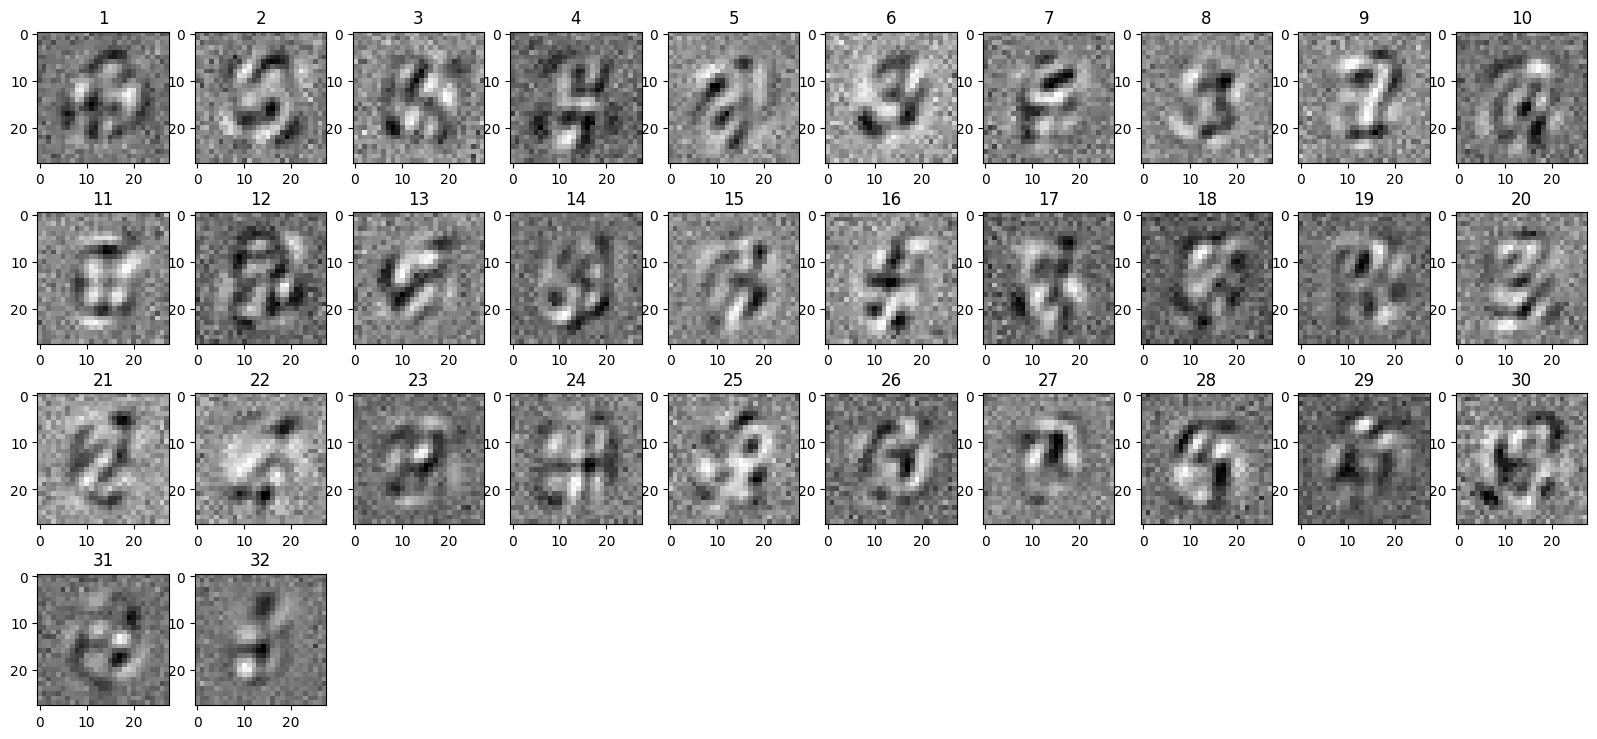

In [74]:
fig = plt.figure(figsize=(20,9))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.imshow(sae_rf_ls[i].reshape(28,28),cmap='binary_r')

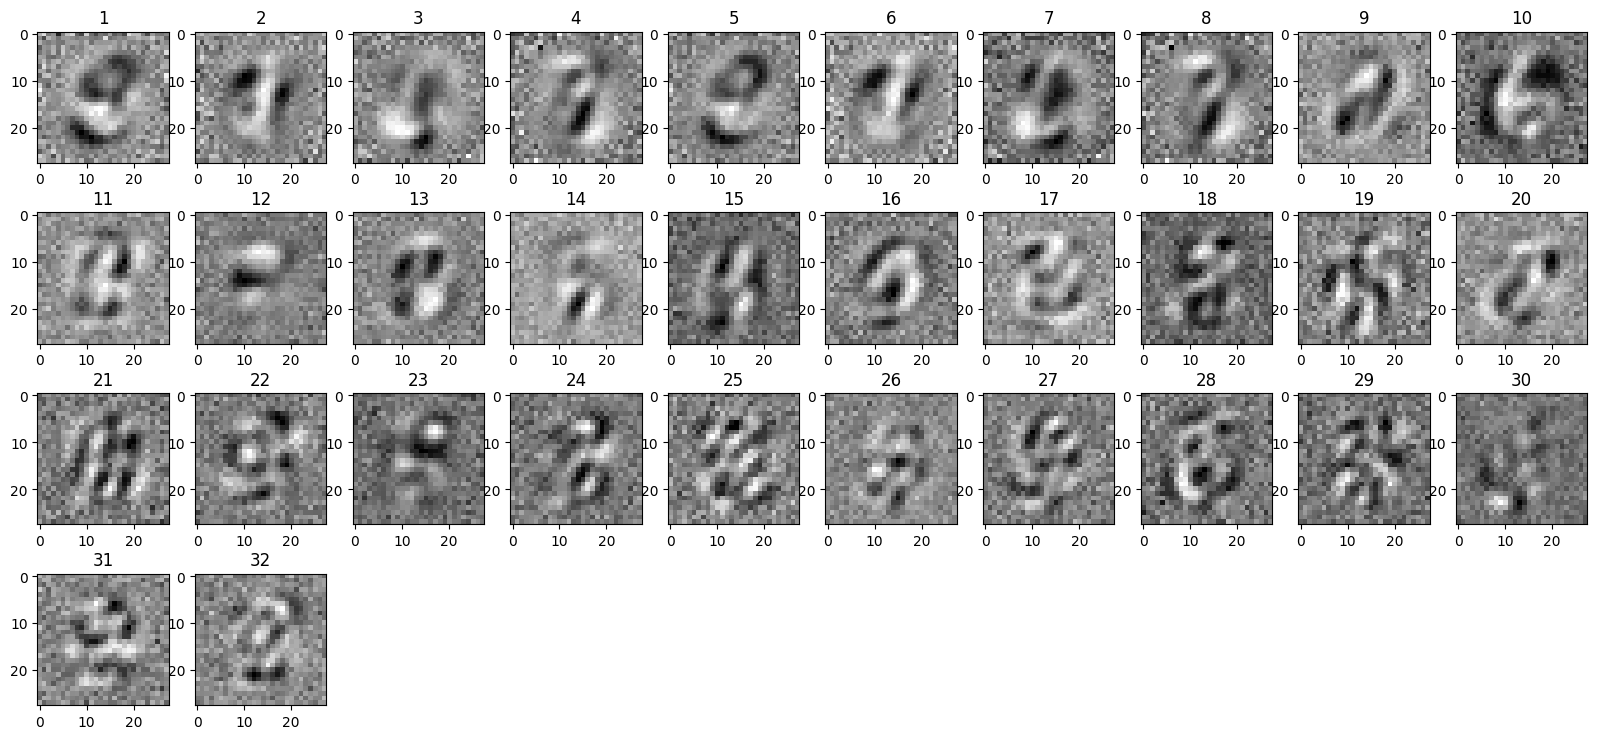

In [75]:
fig = plt.figure(figsize=(20,9))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.imshow(dae_rf_ls[i].reshape(28,28),cmap='binary_r')

In [76]:
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    cos_value = numerator / denominator

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

5 Model

50 Epochs

4 - 32 Neurons

784 Pixels

In [81]:
def pad_matrices(model_ls, target_dim=32):
    padded_data = []
    for epoch_ls in model_ls:
        padded_epoch_ls = []
        for neuron_ls in epoch_ls:
            padding_array = np.zeros((target_dim - len(neuron_ls), 784))
            padded_neuron_ls = np.vstack([neuron_ls, padding_array])
            padded_epoch_ls.append(padded_neuron_ls)
        padded_data.append(padded_epoch_ls)
    return np.array(padded_data)

In [103]:
sae_rf_matrices = np.array(sae_rf_matrices)
sae_rf_matrices.shape

(5, 50, 32, 784)

In [104]:
dae_rf_matrices = pad_matrices(dae_rf_matrices)
dae_rf_matrices.shape

(5, 50, 32, 784)

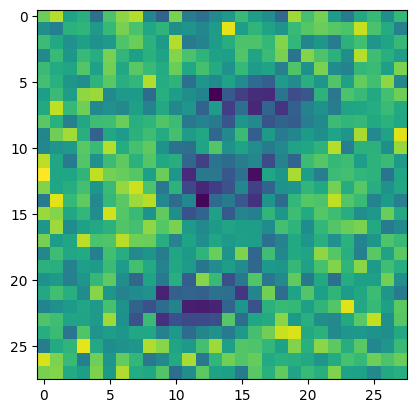

In [36]:
plt.imshow(dae_rf_matrices[0][2][0].reshape(28, 28))

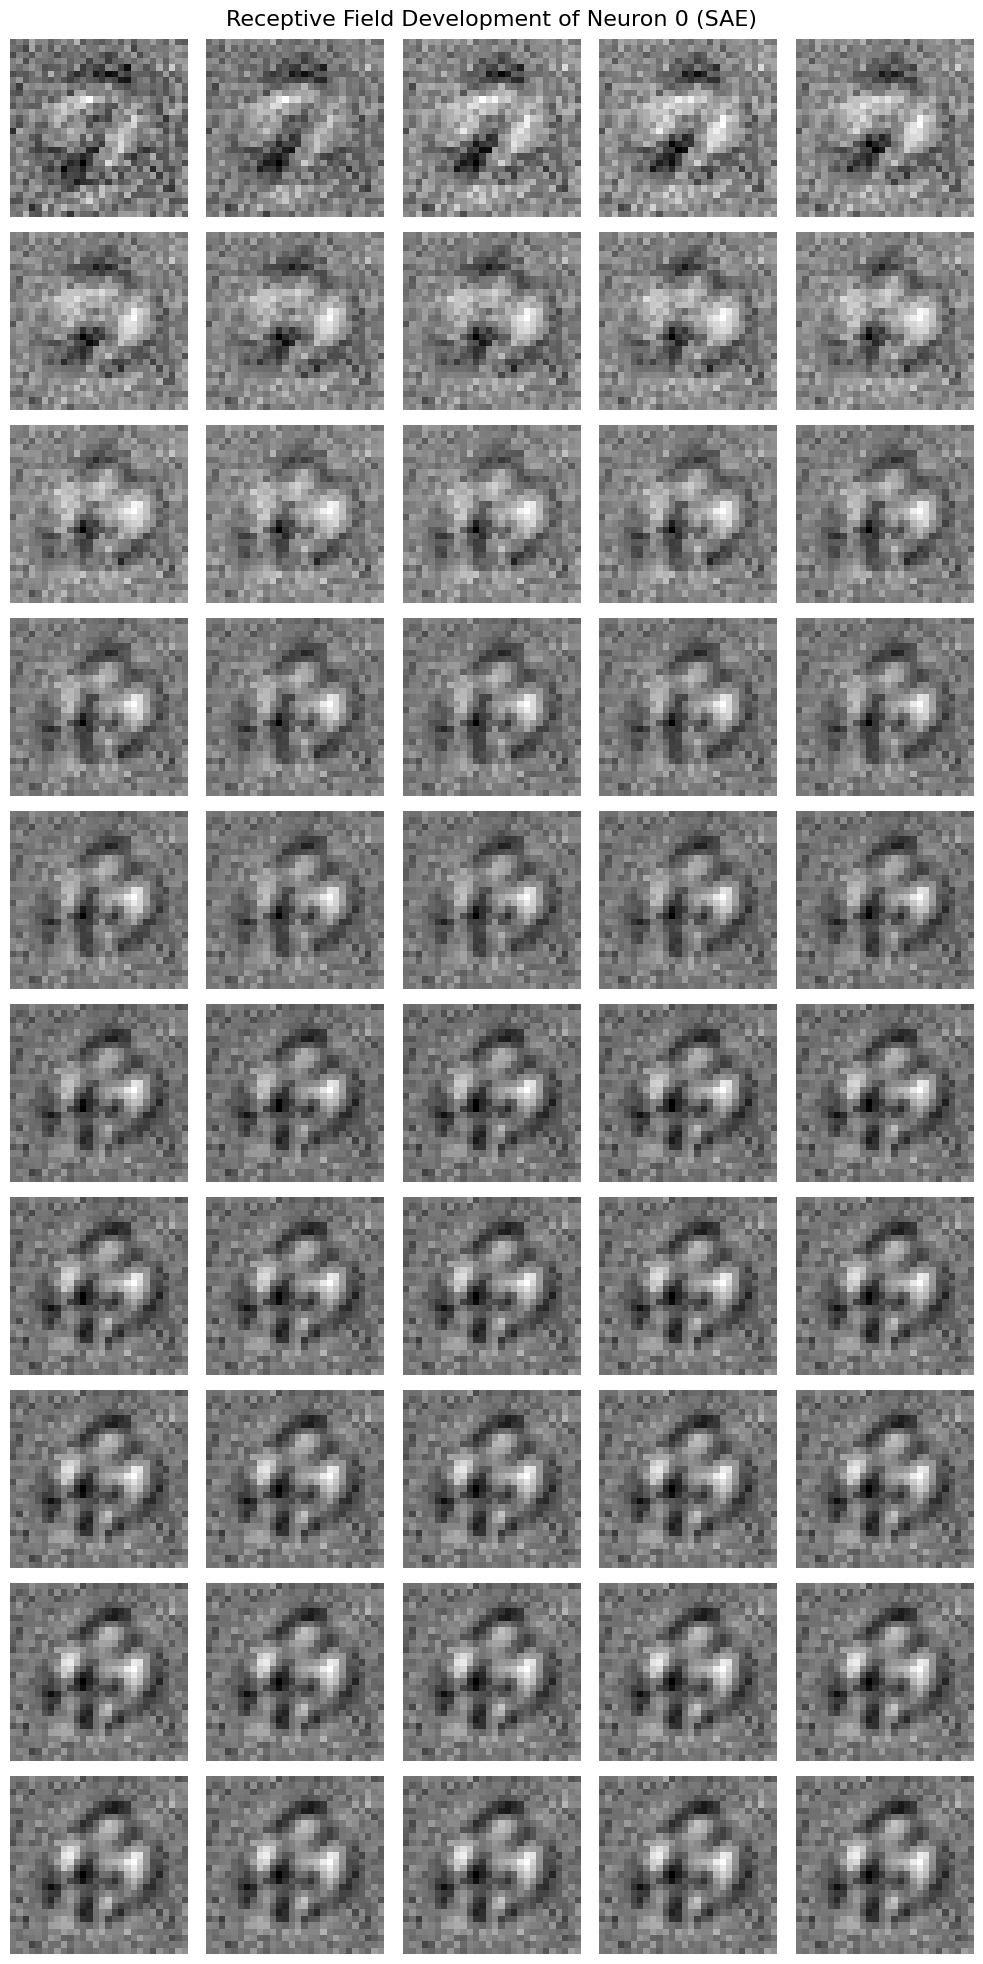

In [51]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(sae_rf_matrices[0][i][0].reshape(28, 28), cmap='binary_r')
    axes[i].axis('off')

fig.suptitle("Receptive Field Development of Neuron 0 (SAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


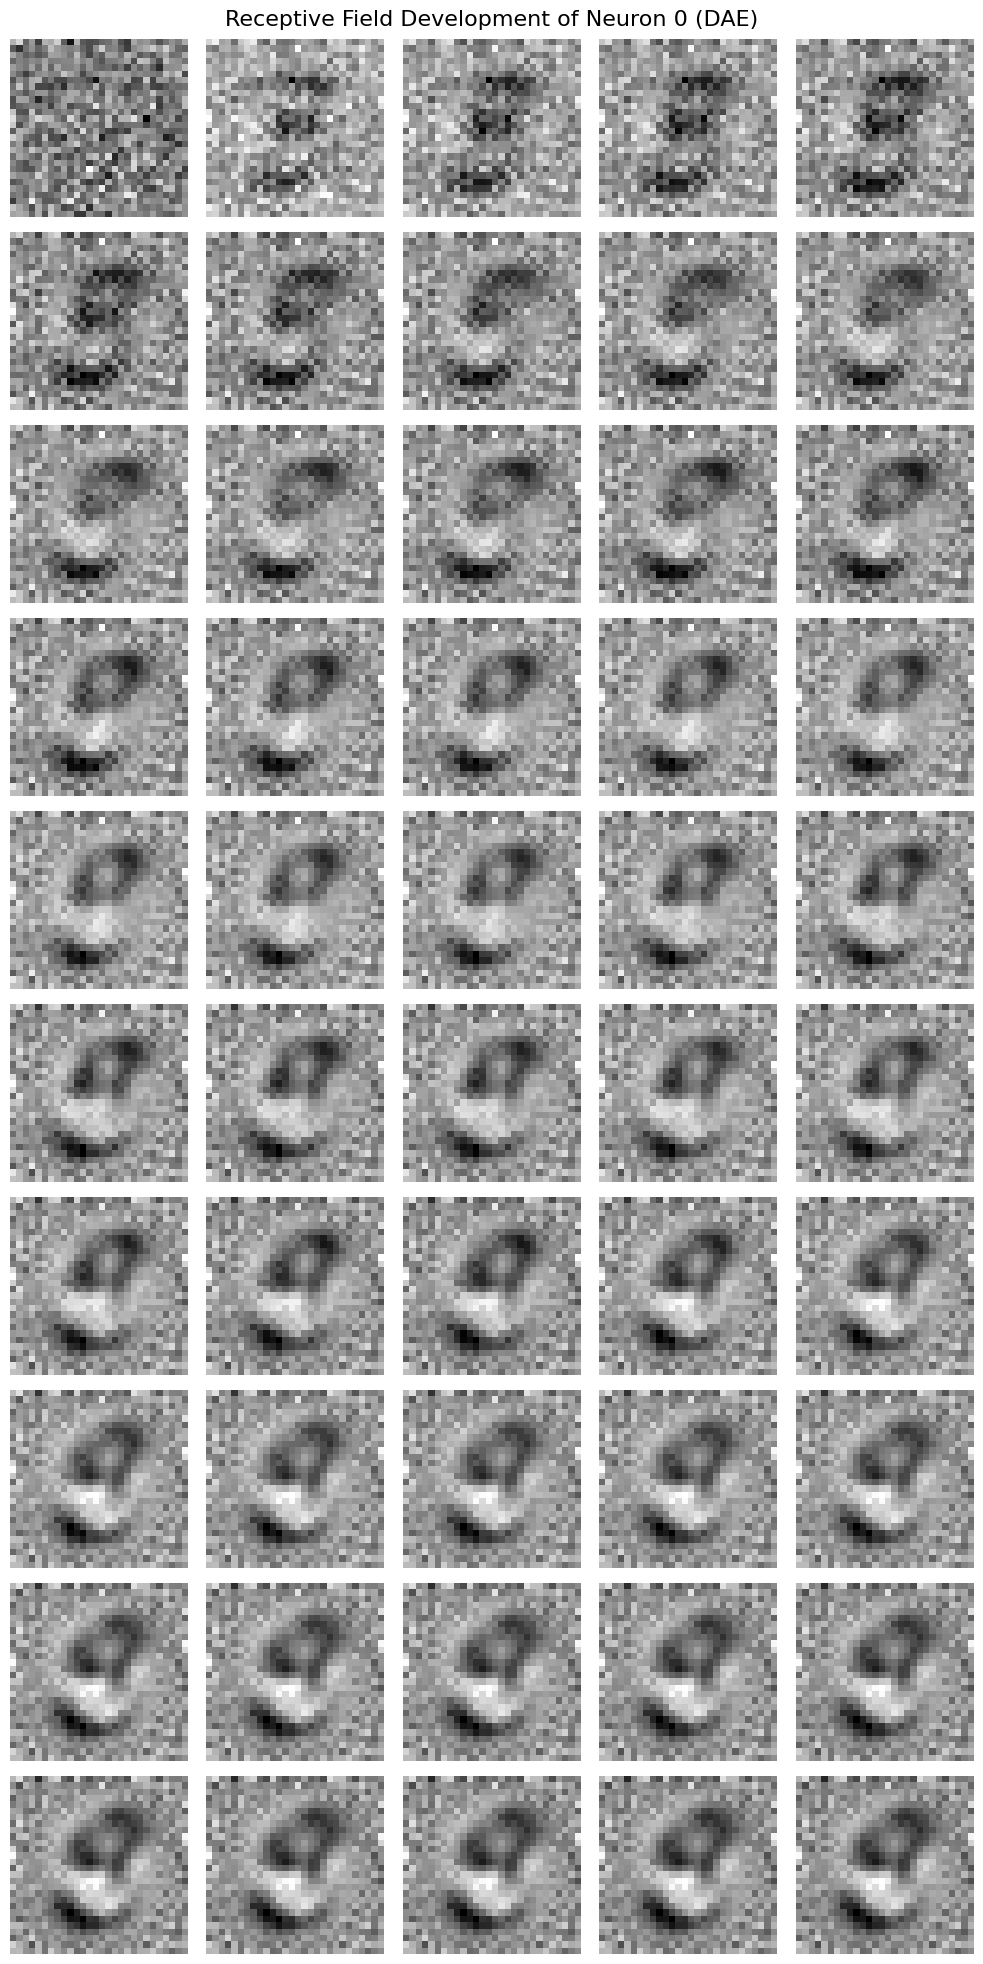

In [55]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
axes = axes.ravel()

for i in range(50):
    axes[i].imshow(dae_rf_matrices[0][i][0].reshape(28, 28), cmap='binary_r')
    axes[i].axis('off')

fig.suptitle("Receptive Field Development of Neuron 0 (DAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

In [ ]:
num_models = 5
num_epochs = 50
num_neurons = 32

sae_angles_matrix = np.zeros((num_models, num_epochs-1, num_neurons))
dae_angles_matrix = np.zeros((num_models, num_epochs-1, num_neurons))

for model in range(num_models):
    for epoch in range(num_epochs-1):
        for neuron in range(num_neurons):
            angle = cosine_angle_between_pcs(dae_rf_matrices[model][epoch][neuron], dae_rf_matrices[model][epoch + 1][neuron])
            dae_angles_matrix[model, epoch, neuron] = angle
            angle = cosine_angle_between_pcs(sae_rf_matrices[model][epoch][neuron], sae_rf_matrices[model][epoch + 1][neuron])
            sae_angles_matrix[model, epoch, neuron] = angle

sae_angles_matrix = np.array(sae_angles_matrix)
dae_angles_matrix = np.array(dae_angles_matrix)

sae_average_angles = np.mean(sae_angles_matrix, axis=0)
dae_average_angles = np.mean(dae_angles_matrix, axis=0)

print(f"Shape of angles array: {sae_angles_matrix.shape}")

Shape of angles array: (5, 49, 32)


/tmp/ipykernel_51757/575378270.py:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_value = numerator / denominator


In [112]:
sae_average_angles.shape

(49, 32)

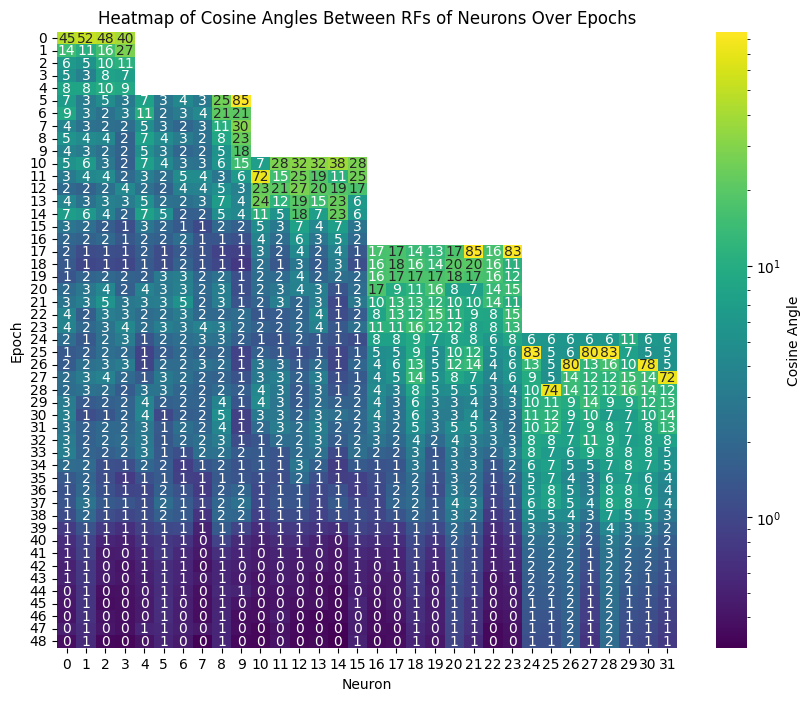

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
sns.heatmap(
    average_angles,
    cmap='viridis',
    annot=True,
    fmt=".0f",
    norm=LogNorm(),
    cbar_kws={'label': 'Cosine Angle'},
    xticklabels=True,
    yticklabels=True
)

plt.xlabel('Neuron')
plt.ylabel('Epoch')
plt.title('Heatmap of Cosine Angles Between RFs of Neurons Over Epochs')
plt.show()

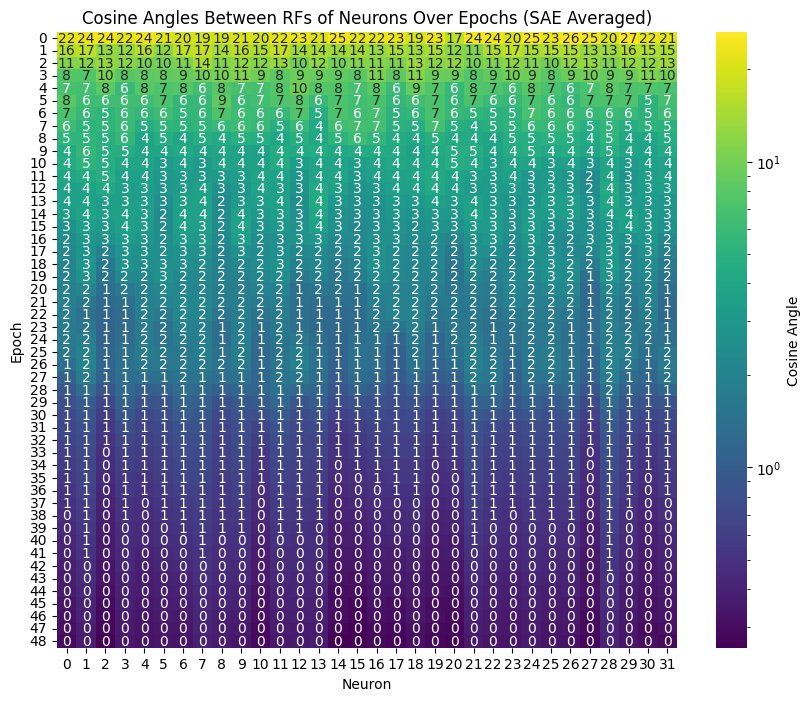

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
sns.heatmap(
    sae_average_angles,
    cmap='viridis',
    annot=True,
    fmt=".0f",
    norm=LogNorm(),
    cbar_kws={'label': 'Cosine Angle'},
    xticklabels=True,
    yticklabels=True
)

plt.xlabel('Neuron')
plt.ylabel('Epoch')
plt.title('Cosine Angles Between RFs of Neurons Over Epochs (SAE Averaged)')
plt.show()

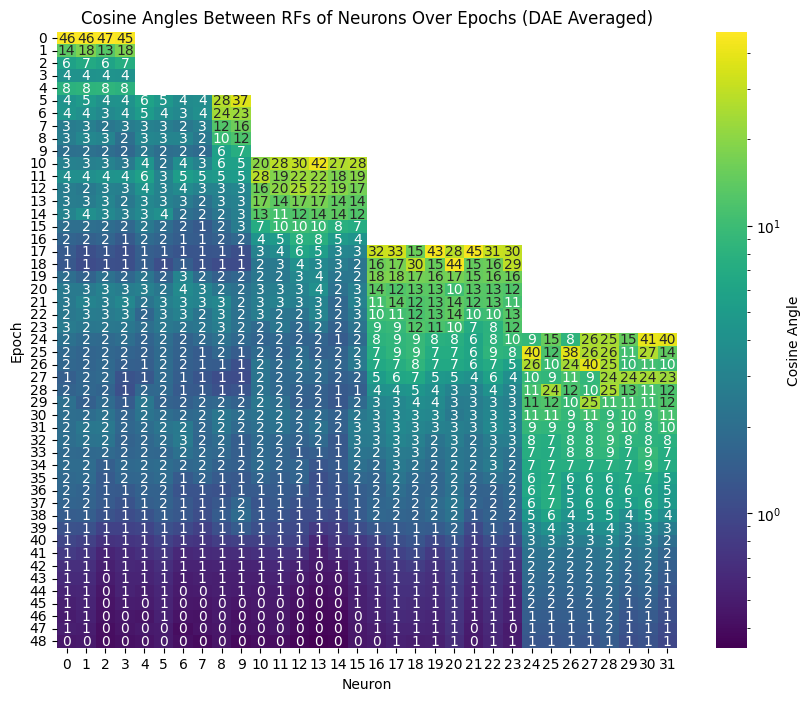

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
sns.heatmap(
    dae_average_angles,
    cmap='viridis',
    annot=True,
    fmt=".0f",
    norm=LogNorm(),
    cbar_kws={'label': 'Cosine Angle'},
    xticklabels=True,
    yticklabels=True
)

plt.xlabel('Neuron')
plt.ylabel('Epoch')
plt.title('Cosine Angles Between RFs of Neurons Over Epochs (DAE Averaged)')
plt.show()